In [1]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer
import matplotlib.pyplot as plt
import math
from torch.distributions import Independent, Distribution
from sbi.types import Array, OneOrMore, ScalarFloat
import numpy as np

In [2]:
def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

In [3]:
class fabricated_priors(Distribution): 
    
    '''
    This class takes in two lists of tensors containing either lower and upper limits or 
    mean and std deviation of the paramters in the prior. 
    
    Prior = fabricated_priors(low/mean =torch.tensor([a1,b1,...]), up/std = torch.tensor([a2,b2,...]))
    
    In the function log_prob, their distribution is identified based on the order of the parameters.
    Funtion normal_dist is invoked for a normal dist and function uniform_dist for a uniform distribution. 
    It returns with a value of log probability. Similarly for sampling in the method sample. 
    
    It contains two methods, log_prob and sample. 
    
    Args:
    
    low: list of tensors of the lower values/mean of various parameters. 
    high: list of tensors of the upper values/std deviation of various parameters.
    
    Returns:
    A sample of each parameter distribution within the required range.    
    
    '''
    
    def __init__(self, a,b, validate_args=None):
        #ranges of distributions
        
        self._mean = a[:1]
        self._std = b[:1]
        self._low = a[1:]   
        self._high = b[1:]
        
        batch_shape= a.size()
        event_shape = torch.tensor([])
        
        super(fabricated_priors, self).__init__(batch_shape, validate_args=validate_args)
        
    def normal_dist(self, value):
        #print('vn:', value)
        var = (self._std ** 2)
        log_scale = math.log(self._std) 
        #print('n: ',torch.sum(-((value - self._mean) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))))
        return torch.sum(-((value - self._mean) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi)))
    
    def sample_normal(self, sample_shape=torch.Size()):
        shape = sample_shape + self._mean.size()
        return torch.normal(self._mean.expand(shape), self._std.expand(shape))

    def uniform_dist(self, value):
        #print('vu:', value)
        lb = self._low.le(value).type_as(self._low)
        ub = self._high.gt(value).type_as(self._low)
        #print('u: ', torch.sum(torch.log(lb.mul(ub)) - torch.log(self._high - self._low)))
        return torch.sum(torch.log(lb.mul(ub)) - torch.log(self._high - self._low))

    def sample_uniform(self, sample_shape=torch.Size()):
        shape = sample_shape + self._low.size()
        rand = torch.rand(shape, dtype=self._low.dtype, device=self._low.device)
        return self._low + rand * (self._high - self._low)
    
    def log_prob(self, value): #vlaue = torch.tensor([a,b,c,...])- values picked 
        
        log_prob = self.normal_dist(value[0,:1])+ self.uniform_dist(value[0,1:]) #sum
        log_prob = log_prob.unsqueeze(-1).T
        log_prob = log_prob.unsqueeze(-1).T
        return log_prob        
                
    def sample(self, sample_shape= torch.Size()): 
        n = self.sample_normal(sample_shape)
        u = self.sample_uniform(sample_shape)
        if sample_shape == torch.Size([]):
            n = n.unsqueeze(-1).T
            u = u.unsqueeze(-1).T
        samp = torch.cat((n, u), 1)
        return samp
        
        

In [4]:
class BoxUniform_new(Independent):
    def __init__(
        self, a: ScalarFloat, b: ScalarFloat, reinterpreted_batch_ndims: int = 1,
    ):
        """Multidimensional uniform distribution defined on a box.
        A `Uniform` distribution initialized with e.g. a parameter vector low or high of
         length 3 will result in a /batch/ dimension of length 3. A log_prob evaluation
         will then output three numbers, one for each of the independent Uniforms in
         the batch. Instead, a `BoxUniform` initialized in the same way has three
         /event/ dimensions, and returns a scalar log_prob corresponding to whether
         the evaluated point is in the box defined by low and high or outside.
        Refer to torch.distributions.Uniform and torch.distributions.Independent for
         further documentation.
        Args:
            low: lower range (inclusive).
            high: upper range (exclusive).
            reinterpreted_batch_ndims (int): the number of batch dims to
                                             reinterpret as event dims.
        """

        super().__init__(fabricated_priors(a=a, b=b), reinterpreted_batch_ndims)

In [5]:
p = BoxUniform_new(torch.tensor([0.5,6,7,10]), torch.tensor([0.1,10,12,12]))
#pp = utils.BoxUniform(torch.tensor([0.5, 0.6, 0.7]), torch.tensor([0.7, 0.8,1.0]))

In [6]:
posterior = infer(simulator, p , method='SNRE_a', num_simulations=1000)


Neural network successfully converged after 65 epochs.


In [7]:
observation = simulator(torch.tensor([0.5, 8, 10, 11]))

In [8]:
samples = posterior.sample((100,), x=observation)

Generating samples: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


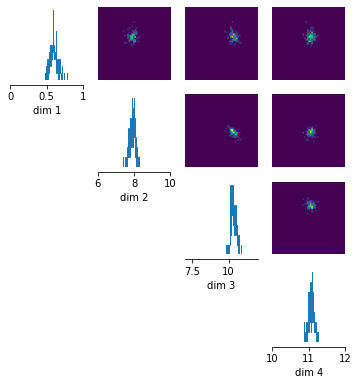

In [9]:
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples, limits=[[0,1],[6,10],[7,12],[10,12]], fig_size=(6,6))

In [3]:
import numpy as np

In [4]:
a= [1,2,3,4]
np.shape(a)

(4,)